<a href="https://colab.research.google.com/github/sahil4129/ML-For-Beginners/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

## Load libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.5.0


## Load dataset

In [2]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL  = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"

train_file_path = tf.keras.utils.get_file("train-data.tsv", TRAIN_DATA_URL)
test_file_path  = tf.keras.utils.get_file("valid-data.tsv", TEST_DATA_URL)

122880/118774 [===============================] - 0s 0us/step


In [3]:
print(train_file_path)
print(test_file_path)

/root/.keras/datasets/train-data.tsv
/root/.keras/datasets/valid-data.tsv


In [4]:
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=['y', 'x'])
df_train.head()

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [5]:
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['y', 'x'])
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [6]:
print(len(df_train))
print(len(df_test))

4179
1392


## Handle categorical values

In [7]:
y_train = df_train['y'].astype('category').cat.codes
y_test  = df_test['y'].astype('category').cat.codes
y_train[:5]

0    0
1    0
2    0
3    0
4    0
dtype: int8

Text(0.5, 1.0, 'Number of ham and spam messages')

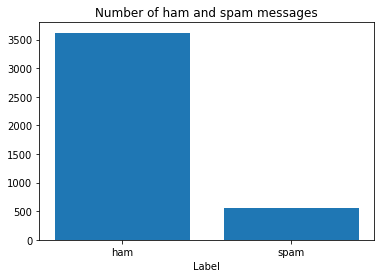

In [8]:
bar = df_train['y'].value_counts()

plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

## Text preprocessing

In [9]:
import nltk
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [11]:
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [12]:
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

179

In [13]:
lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

In [14]:
X_train = df_train['x'].apply(lambda x: clean_txt(x))
X_train[:5]

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: x, dtype: object

## Vectorize

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [16]:
# Keep top 1000 frequently occurring words
max_words = 1000

# Cut off the words after seeing 500 words in each document
max_len = 500

In [17]:
t = Tokenizer(num_words=max_words)
t.fit_on_texts(X_train)

In [18]:
# Transform each text to a sequence of integers
sequences = t.texts_to_sequences(X_train)
sequences[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [19]:
# Make all rows of equal length
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix[:5]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]], dtype=int32)

## Build model

In [20]:
i = tf.keras.layers.Input(shape=[max_len])
x = tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(i)
x = tf.keras.layers.LSTM(64)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________

In [23]:
r = model.fit(sequences_matrix, y_train,
              batch_size=128, epochs=10,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
27/27 [==============================] - 19s 608ms/step - loss: 0.3453 - accuracy: 0.8789 - val_loss: 0.1298 - val_accuracy: 0.9749


## Evaluate

In [21]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

NameError: ignored

In [22]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

NameError: ignored

In [ ]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return sequence.pad_sequences(x, maxlen=max_len)

In [ ]:
s = model.evaluate(preprocessing(df_test['x']), y_test)

44/44 [==============================] - 3s 65ms/step - loss: 0.0956 - accuracy: 0.9842


In [ ]:
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(s[0], s[1]))

Loss: 0.096, Accuracy: 0.984


## Challenge

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

(0.0, 'ham')


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
